In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb

# Video segmentation with EdgeTAM

This notebook shows how to use EdgeTAM for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

## Environment Set-up

If running locally using jupyter, first install `EdgeTAM` in your environment using the installation instructions in the repository.

## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

Unable to revert mtime: /Library/Fonts
Matplotlib is building the font cache; this may take a moment.


In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. EdgeTAM is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. EdgeTAM is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


In [3]:
pip install -e .

Obtaining file:///Users/nandinilreddy/Desktop/edgeTam/EdgeTAM/notebooks
ERROR: file:///Users/nandinilreddy/Desktop/edgeTam/EdgeTAM/notebooks does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


### Loading the SAM 2 video predictor

In [10]:
from sam2.build_sam import build_sam2_video_predictor
checkpoint = "../checkpoints/edgetam.pt"
model_cfg = "edgetam"

predictor = build_sam2_video_predictor(model_cfg, checkpoint, device=device)

configuration solved
model instantiated
checkpoint loaded
model ready


In [11]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

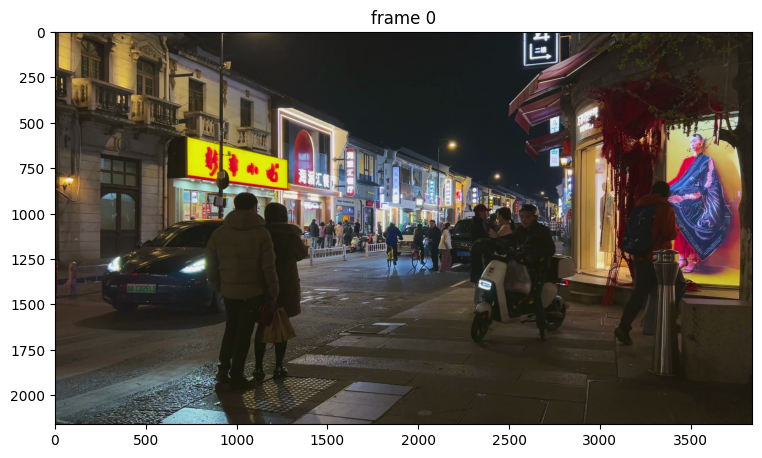

In [47]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/pedestrain-frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [48]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 51/51 [00:05<00:00,  9.64it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [49]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

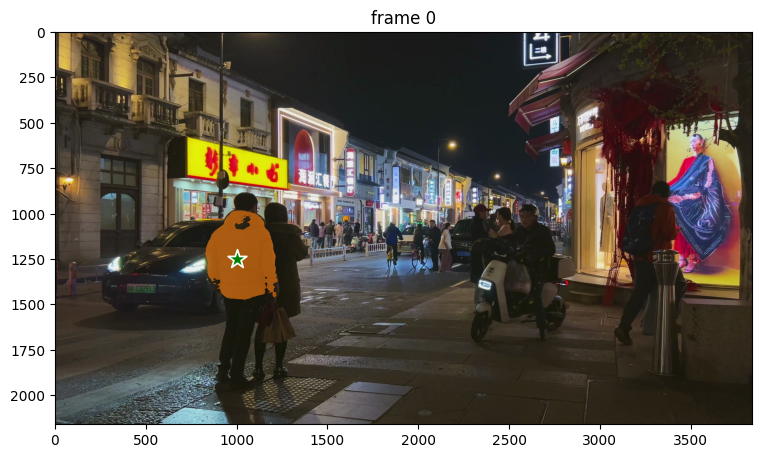

In [50]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[1000,1250]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: Add a second click to refine the prediction

Hmm, it seems that although we wanted to segment the child on the left, the model predicts the mask for only the shorts -- this can happen since there is ambiguity from a single click about what the target object should be. We can refine the mask on this frame via another positive click on the child's shirt.

Here we make a **second positive click** at (x, y) = (250, 220) with label `1` to expand the mask.

Note: we need to send **all the clicks and their labels** (i.e. not just the last click) when calling `add_new_points_or_box`.

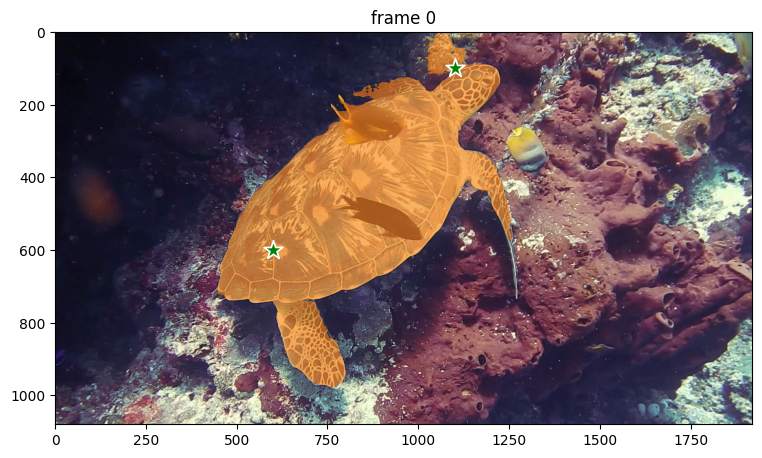

In [35]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[600, 600], [1100, 100]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

With this 2nd refinement click, now we get a segmentation mask of the entire child on frame 0.

#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video: 100%|██████████| 31/31 [00:08<00:00,  3.54it/s]


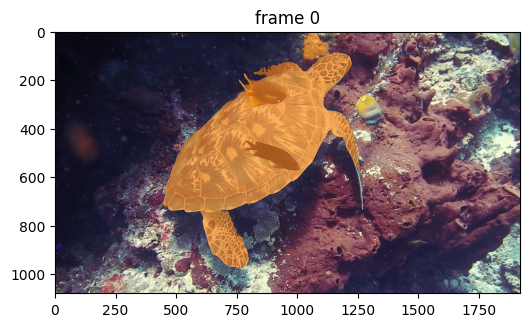

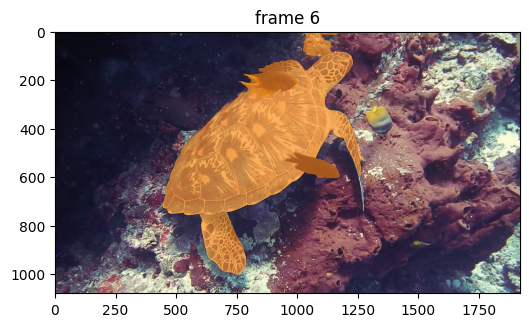

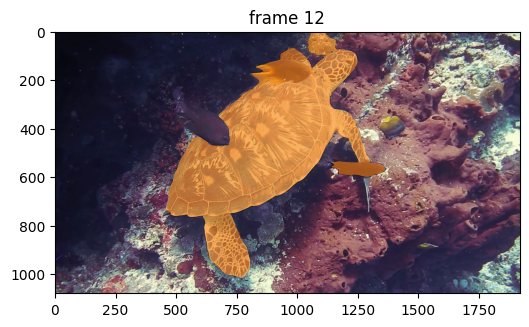

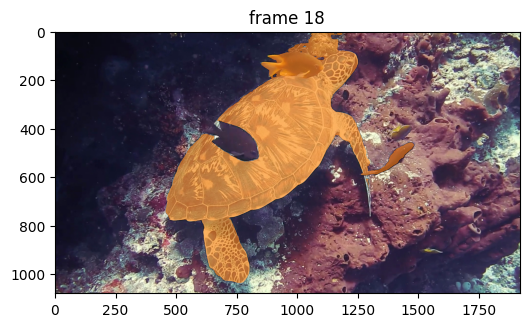

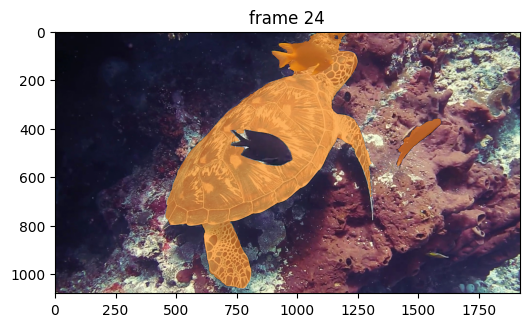

In [39]:
# Run propagation and collect results
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# Visualize key frames - only use frames that exist
vis_frame_stride = 6
plt.close("all")
for out_frame_idx in range(0, min(len(frame_names), 30), vis_frame_stride):
    if out_frame_idx < len(frame_names):  # Safety check
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.show()

using device: mps

Support for MPS devices is preliminary. EdgeTAM is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.
configuration solved
model instantiated
checkpoint loaded
model ready
Found 51 frames


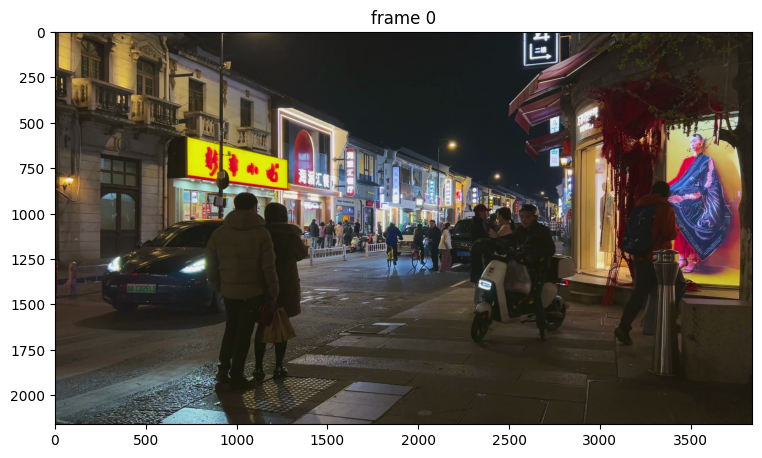

frame loading (JPEG): 100%|██████████| 51/51 [00:05<00:00, 10.16it/s]


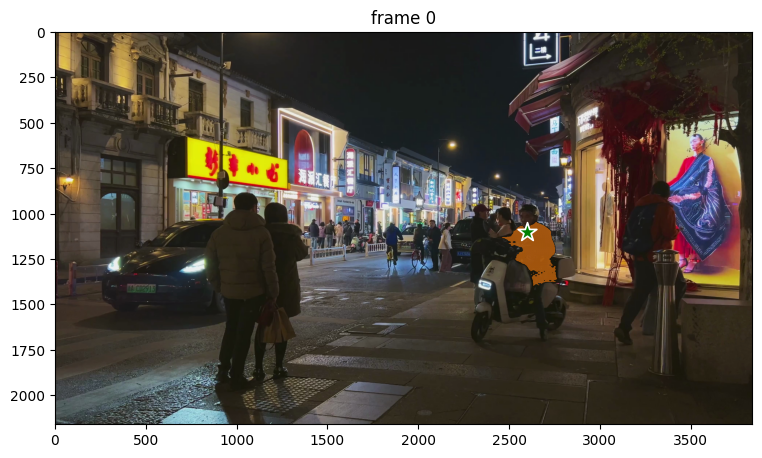

Starting video propagation...


propagate in video:   0%|          | 0/51 [00:00<?, ?it/s]

Processed frame 0


propagate in video:  12%|█▏        | 6/51 [00:01<00:12,  3.54it/s]

Processed frame 5


propagate in video:  22%|██▏       | 11/51 [00:03<00:13,  3.05it/s]

Processed frame 10


propagate in video:  31%|███▏      | 16/51 [00:05<00:10,  3.22it/s]

Processed frame 15


propagate in video:  41%|████      | 21/51 [00:06<00:09,  3.29it/s]

Processed frame 20


propagate in video:  51%|█████     | 26/51 [00:08<00:07,  3.32it/s]

Processed frame 25


propagate in video:  61%|██████    | 31/51 [00:09<00:06,  3.18it/s]

Processed frame 30


propagate in video:  71%|███████   | 36/51 [00:11<00:05,  2.57it/s]

Processed frame 35


propagate in video:  80%|████████  | 41/51 [00:13<00:03,  3.13it/s]

Processed frame 40


propagate in video:  90%|█████████ | 46/51 [00:14<00:01,  3.31it/s]

Processed frame 45


propagate in video: 100%|██████████| 51/51 [00:16<00:00,  3.09it/s]

Processed frame 50
Propagation completed! Processed 51 frames
Creating MP4 video...


Writing frame 0/51
Writing frame 5/51
Writing frame 10/51
Writing frame 15/51
Writing frame 20/51
Writing frame 25/51
Writing frame 30/51
Writing frame 35/51
Writing frame 40/51
Writing frame 45/51
Writing frame 50/51
✅ Video creation completed!
📹 Output saved as: wildlife_tracking_output.mp4
📊 Processed 51 frames tracking the sea turtle

Showing sample tracking results...


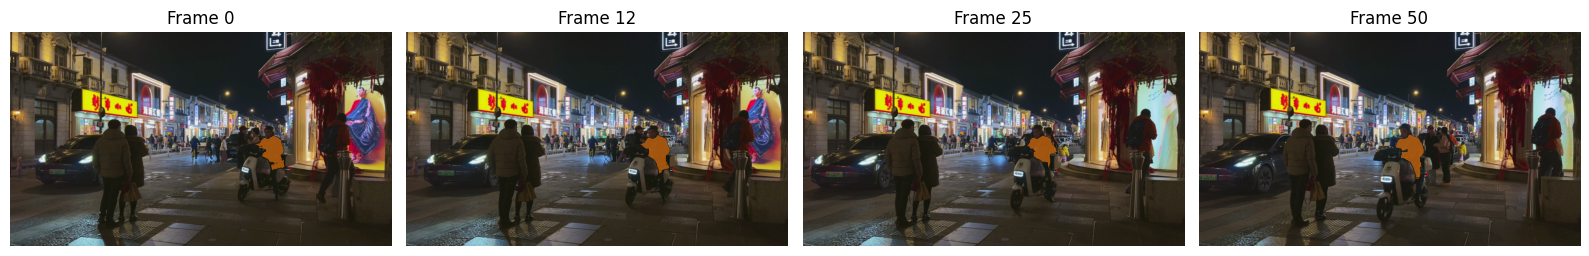

🎬 Check the wildlife_tracking_output.mp4 file for the complete tracking video!


In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sam2.build_sam import build_sam2_video_predictor

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. EdgeTAM is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

# Build the predictor
checkpoint = "../checkpoints/edgetam.pt"
model_cfg = "edgetam"
predictor = build_sam2_video_predictor(model_cfg, checkpoint, device=device)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# Load video frames
video_dir = "./videos/pedestrain-frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

print(f"Found {len(frame_names)} frames")

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
plt.show()

# Initialize inference state
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

# Add tracking points
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with

# Add point for turtle only
points = np.array([[2600, 1100]], dtype=np.float32)
labels = np.array([1], np.int32)  # 1 means positive click

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
plt.show()

# Run propagation and collect results for all frames
print("Starting video propagation...")
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    if out_frame_idx % 5 == 0:
        print(f"Processed frame {out_frame_idx}")

print(f"Propagation completed! Processed {len(video_segments)} frames")

# Create MP4 video with tracking results
print("Creating MP4 video...")

# Get frame dimensions
first_frame = cv2.imread(os.path.join(video_dir, frame_names[0]))
height, width = first_frame.shape[:2]

# Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_video = cv2.VideoWriter("pedestrain_tracking_output2.mp4", fourcc, 5, (width, height))

# Colors for turtle (BGR format for OpenCV)
turtle_color = (0, 0, 255)  # Red

# Process each frame
for frame_idx in range(len(frame_names)):
    # Load frame
    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    frame = cv2.imread(frame_path)
    
    # Apply segmentation mask for turtle
    if frame_idx in video_segments:
        for out_obj_id, mask in video_segments[frame_idx].items():
            # Handle mask dimensions - mask might be 2D while frame is 3D
            if len(mask.shape) == 2:
                mask_2d = mask
            else:
                mask_2d = mask.squeeze()
            
            # Ensure mask matches frame dimensions
            if mask_2d.shape != (height, width):
                print(f"Warning: Mask shape {mask_2d.shape} doesn't match frame shape {(height, width)}")
                continue
            
            # Create colored mask overlay for turtle
            colored_mask = np.zeros_like(frame)
            colored_mask[mask_2d] = turtle_color
            
            # Blend with original frame (70% original, 30% mask)
            frame = cv2.addWeighted(frame, 0.7, colored_mask, 0.3, 0)
            
            # Add turtle label
            mask_coords = np.where(mask_2d)
            if len(mask_coords[0]) > 0:
                centroid_y = int(mask_coords[0].mean())
                centroid_x = int(mask_coords[1].mean())
                cv2.putText(frame, "person", 
                          (centroid_x-50, centroid_y-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
                cv2.circle(frame, (centroid_x, centroid_y), 5, (255, 255, 255), -1)
    
    # Add frame number and info
    cv2.putText(frame, f"Frame {frame_idx}/{len(frame_names)-1}", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(frame, f"Time: {frame_idx*0.2:.1f}s", (10, 70), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # Write frame to video
    out_video.write(frame)
    
    if frame_idx % 5 == 0:
        print(f"Writing frame {frame_idx}/{len(frame_names)}")

# Release video writer
out_video.release()

print("✅ Video creation completed!")
print("📹 Output saved as: wildlife_tracking_output.mp4")
print(f"📊 Processed {len(frame_names)} frames tracking the sea turtle")

print("\nShowing sample tracking results...")
sample_frames = [0, len(frame_names)//4, len(frame_names)//2, len(frame_names)-1]

plt.figure(figsize=(16, 4))
for i, frame_idx in enumerate(sample_frames):
    plt.subplot(1, 4, i+1)
    plt.title(f"Frame {frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
    
    if frame_idx in video_segments:
        for out_obj_id, mask in video_segments[frame_idx].items():
            show_mask(mask, plt.gca(), obj_id=out_obj_id)
    
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Check the wildlife_tracking_output.mp4 file for the complete tracking video!")